# Whorls pose estimation

### If required install required packages

In [1]:
#!pip install ultralytics
#!python -m pip install "laspy[lazrs,laszip]"
#!pip install comet_ml 
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

### Load libraries

In [23]:
# Import required libraries
import os, glob, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import laspy
from PIL import Image
import re
from scipy.spatial import cKDTree
import concurrent.futures

# import YOLOv8
import ultralytics
from ultralytics import YOLO

### Load my own custom functions

In [24]:
# TO CLEAN-UP (I am not sure whether all of this functions are needed here)
from tools import rotate_point_cloud,slice_tree_center_thick_slices,plot_to_image,plot_section_as_image_with_alpha
from tools import convert_to_real_world,process_file,calculate_angle_at_p2,calculate_distance,pose_detection_tree
from tools import convert_sections_to_images,process_point_cloud,get_image_size

## Define paths and create required directories for temporary or output files

In [25]:
# directory to where point cloud (*.las or *.laz) forest scenes are stored (they need to have treeIDs for each point!)
dir_root="data"

# directory to where YOLO predictions are stored
dir_output = os.path.join(dir_root, "results")  # path to where to store the final results
dir_pred = os.path.join(dir_root, "pred_temp")  # temp path to where to store the intermediate prediction
dir_temp_imgs = os.path.join(dir_pred, "orig_imgs") # Further subdirectories within 'dir_pred'

# Ensure directories exist without throwing an error if they already do
os.makedirs(dir_pred, exist_ok=True)
os.makedirs(dir_output, exist_ok=True)
os.makedirs(dir_temp_imgs, exist_ok=True)

# Find all .las and .laz files in the root folder
las_files = glob.glob(os.path.join(dir_root, '*.las'))
laz_files = glob.glob(os.path.join(dir_root, '*.laz'))

# Combine the lists of files
all_files = las_files + laz_files
all_files

['data\\demo_data.laz']

## Define parameters 

In [26]:
# minimum distance between whorls (used to remove duplicates)
min_internodal_d= 0.3 # in m (it can be set to something like 0.01 to allow the full output to post-process later)

# pose model
my_model="whorl_pose_nano_1000px/weights/best.pt"

# label for the column with tree instance unique identifiers
tree_id_label='treeID' 

# label for the column with semantic labels (non required)
semantic_label='semantic' 

## Run for each file in the folder

In [27]:
for filename in all_files:
    print("Processing: "+filename)

Processing: data\demo_data.laz


In [28]:
# DEBUG
# shutil.rmtree(dir_pred)

In [29]:
# Read in the forest segmented data
las = laspy.read(filename)

# convert to a numpy array 
las_np = np.vstack((las.x, las.y, las.z,  getattr(las, tree_id_label),  getattr(las, semantic_label))).transpose()

# split tree/non-tree (assumes that the semantic label corresponds to 0 if it's not a tree and 1 if it is a tree)
trees= las_np[getattr(las, semantic_label)!=0]
non_tree= las_np[getattr(las, semantic_label)==0]

print("tree points: "+ str(round(len(trees)/len(las_np)*100))+"%")
print("Non-tree points: "+ str(round(len(non_tree)/len(las_np)*100))+"%")

tree points: 100%
Non-tree points: 0%


# Whorl detection

In [30]:
# Parallel individual tree whorl pose detection
unique_treeIDs = np.unique(getattr(las, tree_id_label))
results = []

#os.makedirs("test_whorls_maria/forest/pred_temp/preds", exist_ok=True)


with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
    # Submitting tasks to the executor
    future_to_treeID = {
        executor.submit(
            pose_detection_tree, 
            treeID=treeID,         # Pass treeID as a keyword argument
            trees=trees, 
            non_tree=non_tree, 
            dir_root=dir_root, 
            my_model=my_model, 
            dir_pred=dir_pred, 
            min_dist_whorls=min_internodal_d  # Pass min_dist_whorls as a keyword argument
        ): treeID 
        for treeID in unique_treeIDs
    }
    
    # Collecting results as they complete
    for future in concurrent.futures.as_completed(future_to_treeID):
        treeID = future_to_treeID[future]
        try:
            data = future.result()
            if data is not None:
                results.append(data)
        except Exception as exc:
            print(f'TreeID {treeID} generated an exception: {exc}')


WARNING  imgsz=[1000] must be multiple of max stride 32, updating to [1024]
image 1/8 C:\Users\stpu\whorl_pose_detector\data\pred_temp\orig_imgs\25409020\img__x45_section_0_min-78.95_max-75.12_zmin0.00_zmax10.00.png: 1024x416 15 whorlss, 46.0ms
image 2/8 C:\Users\stpu\whorl_pose_detector\data\pred_temp\orig_imgs\25409020\img__x45_section_1_min-78.95_max-75.12_zmin1.39_zmax11.39.png: 1024x416 17 whorlss, 150.0ms
image 3/8 C:\Users\stpu\whorl_pose_detector\data\pred_temp\orig_imgs\25409020\img__x_section_0_min-79.16_max-74.64_zmin0.00_zmax10.00.png: 1024x480 14 whorlss, 47.0ms
image 4/8 C:\Users\stpu\whorl_pose_detector\data\pred_temp\orig_imgs\25409020\img__x_section_1_min-78.94_max-74.64_zmin1.39_zmax11.39.png: 1024x448 13 whorlss, 64.0ms
image 5/8 C:\Users\stpu\whorl_pose_detector\data\pred_temp\orig_imgs\25409020\img__y45_section_0_min7.31_max11.62_zmin0.00_zmax10.00.png: 1024x416 15 whorlss, 8.0ms
image 6/8 C:\Users\stpu\whorl_pose_detector\data\pred_temp\orig_imgs\25409020\img__y4

C:\Users\stpu\whorl_pose_detector\tools.py:378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whorls_pc['x']=top_point[0,0]
C:\Users\stpu\whorl_pose_detector\tools.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whorls_pc['y']=top_point[0,1]
C:\Users\stpu\whorl_pose_detector\tools.py:382: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan


WARNING  imgsz=[1000] must be multiple of max stride 32, updating to [1024]
image 1/16 C:\Users\stpu\whorl_pose_detector\data\pred_temp\orig_imgs\132\img__x45_section_0_min-91.70_max-86.22_zmin0.00_zmax10.00.png: 1024x576 15 whorlss, 47.0ms
image 2/16 C:\Users\stpu\whorl_pose_detector\data\pred_temp\orig_imgs\132\img__x45_section_1_min-92.89_max-84.97_zmin10.00_zmax20.00.png: 1024x832 7 whorlss, 52.0ms
image 3/16 C:\Users\stpu\whorl_pose_detector\data\pred_temp\orig_imgs\132\img__x45_section_2_min-92.64_max-84.99_zmin20.00_zmax30.00.png: 1024x800 11 whorlss, 46.0ms
image 4/16 C:\Users\stpu\whorl_pose_detector\data\pred_temp\orig_imgs\132\img__x45_section_3_min-92.20_max-85.43_zmin21.86_zmax31.86.png: 1024x704 13 whorlss, 70.0ms
image 5/16 C:\Users\stpu\whorl_pose_detector\data\pred_temp\orig_imgs\132\img__x_section_0_min-91.47_max-85.32_zmin0.00_zmax10.00.png: 1024x640 16 whorlss, 46.0ms
image 6/16 C:\Users\stpu\whorl_pose_detector\data\pred_temp\orig_imgs\132\img__x_section_1_min-92.

C:\Users\stpu\whorl_pose_detector\tools.py:201: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(np.clip(dot_product / (norm_p2_p1 * norm_p2_p3), -1.0, 1.0))
C:\Users\stpu\whorl_pose_detector\tools.py:378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whorls_pc['x']=top_point[0,0]
C:\Users\stpu\whorl_pose_detector\tools.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whorls_pc['y']=top_point[0,1]
C:\Users\stpu\whorl_pose_detector\tools.py:382: SettingWithCopyWarning: 
A v

In [31]:
# DEBUG
#shutil.rmtree("C:/Users/stpu/whorl_pose_detector/test_whorls_maria/forest/pred_temp/orig_imgs")

## Post-processing of the predictions

In [32]:
# Post-processing the results
# Creating a dictionary mapping treeID to its result
results_dict = {result['treeID']: result['result'] for result in results if result is not None}

# Merging the 'whorl_pc' DataFrames from each result
whorls_pc_dfs = [result['whorl_pc'] for result in results if result is not None and 'whorl_pc' in result]
whorld_df = pd.concat(whorls_pc_dfs, ignore_index=True)

# correct z
whorld_df.loc[whorld_df['branch_opening_angle'] == 0, 'z'] = whorld_df['world_pz2']

# remove negative whorls
whorld_df= whorld_df[whorld_df['world_pz2']>=0]


# write out the output
whorld_df.to_csv(dir_output+'/'+os.path.splitext(os.path.basename(filename))[0]+'_'+str(round(min_internodal_d*100))+'cmThresh_whorls_pc_HKL2model.csv', index=False)  


In [33]:
print(whorld_df)

    world_px2   world_pz2  confidence_p2  branch_opening_angle  \
0  -76.553569    0.085739       0.882854              1.884084   
1    9.856064    0.467966       0.999231            156.861646   
2  -76.672709    0.913543       0.999803            145.067162   
3  -76.483916    1.246220       0.999250            158.804851   
4  -76.603355    1.704290       0.999812            163.366194   
..        ...         ...            ...                   ...   
62   7.679241   29.517490       0.998892            157.245744   
63 -89.670149   30.704860       0.998494            157.588909   
64 -89.696508   31.218720       0.999333            156.150591   
65   6.992755   31.713080       0.804490            163.132294   
66 -88.084000  238.030000       1.000000              0.000000   

    max_branch_length  average_branch_length       x      y           z  \
0            2.607841               1.346790 -76.697  9.226  206.642739   
1            1.226754               0.866217 -76.697  9.2

## Some useful plots

#### Tree silouettes with detected whorls overalyed
this is a useful plot to just check how the model is predicting and to eventually tune the min_internodal_d to reduce the number of detected whorls

C:\Users\stpu\.conda\envs\whorl_pose_detector\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


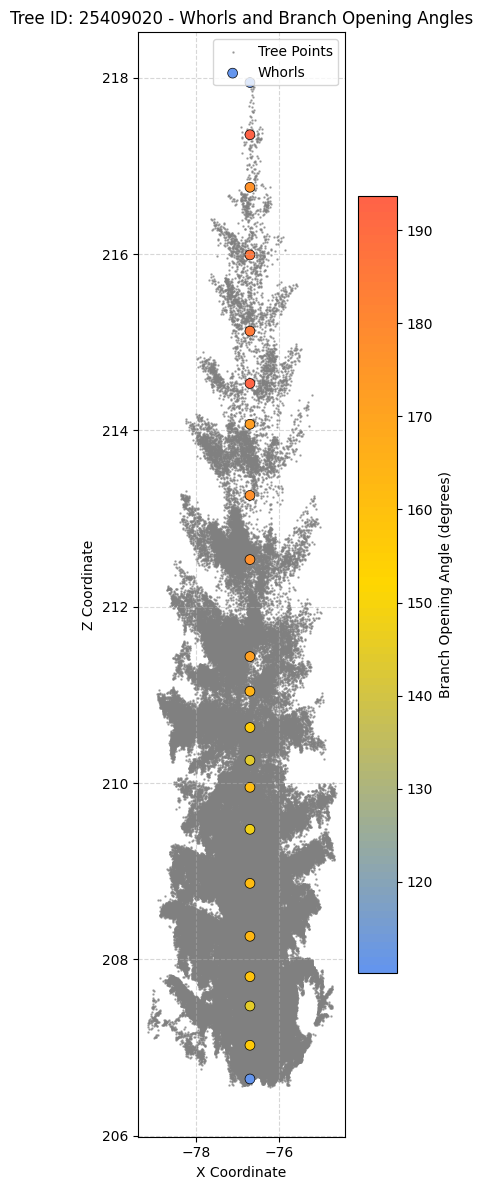

C:\Users\stpu\AppData\Local\Temp\ipykernel_9328\994722217.py:67: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


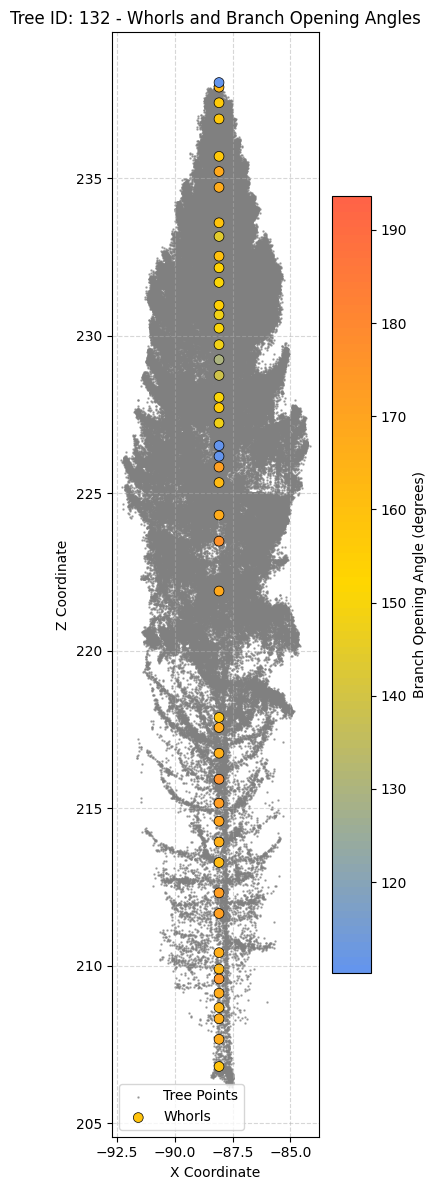

In [37]:
from matplotlib.colors import LinearSegmentedColormap

# Convert LAS data to DataFrame for easy filtering
las_df = pd.DataFrame(las_np, columns=['x', 'y', 'z', 'treeID', 'semantic'])

# Extract unique tree IDs from whorld_df
common_tree_ids = whorld_df['treeID'].unique()

# Calculate mean and standard deviation for 'branch_opening_angle'
mean_angle = whorld_df['branch_opening_angle'].mean()
std_angle = whorld_df['branch_opening_angle'].std()

# Define the range for normalization as mean ± std
vmin = mean_angle - std_angle
vmax = mean_angle + std_angle

# Define a custom colormap: from strong blue to mild white to strong red
colors = ['cornflowerblue', 'gold', 'tomato']  # low -> medium -> high
n_bins = 100  # Number of bins for the colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=n_bins)

# Iterate over each treeID and generate plots
for tree_id in common_tree_ids:
    # Filter data for the current tree
    las_tree = las_df[las_df['treeID'] == tree_id]
    whorl_tree = whorld_df[whorld_df['treeID'] == tree_id]
    
    # Create figure and axis
    plt.figure(figsize=(4, 12))
    
    # Plot LAS points for the current tree
    plt.scatter(
        las_tree['x'],
        las_tree['z'],
        s=0.5,
        c='gray',
        label='Tree Points',
        alpha=0.7
    )
    
    # Normalize 'branch_opening_angle' values within vmin and vmax
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    
    # Plot whorls with colors based on 'branch_opening_angle'
    sc = plt.scatter(
        whorl_tree['x'],
        whorl_tree['z'],
        s=50,
        c=whorl_tree['branch_opening_angle'],
        cmap=custom_cmap,
        norm=norm,
        edgecolor='black',
        linewidth=0.5,
        label='Whorls'
    )
    
    # Add colorbar
    cbar = plt.colorbar(sc)
    cbar.set_label('Branch Opening Angle (degrees)')
    
    # Labeling and titles
    plt.xlabel('X Coordinate')
    plt.ylabel('Z Coordinate')
    plt.title(f'Tree ID: {tree_id} - Whorls and Branch Opening Angles')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    # Optional: Save plot to file
    # plt.savefig(f'tree_{tree_id}_whorls_plot.png', dpi=300)
    # plt.close()

#### Plot the Annual height growth 

C:\Users\stpu\AppData\Local\Temp\ipykernel_9328\33480702.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(common_tree_ids))  # 'tab10' can distinguish up to 10 trees, 'tab20' for more


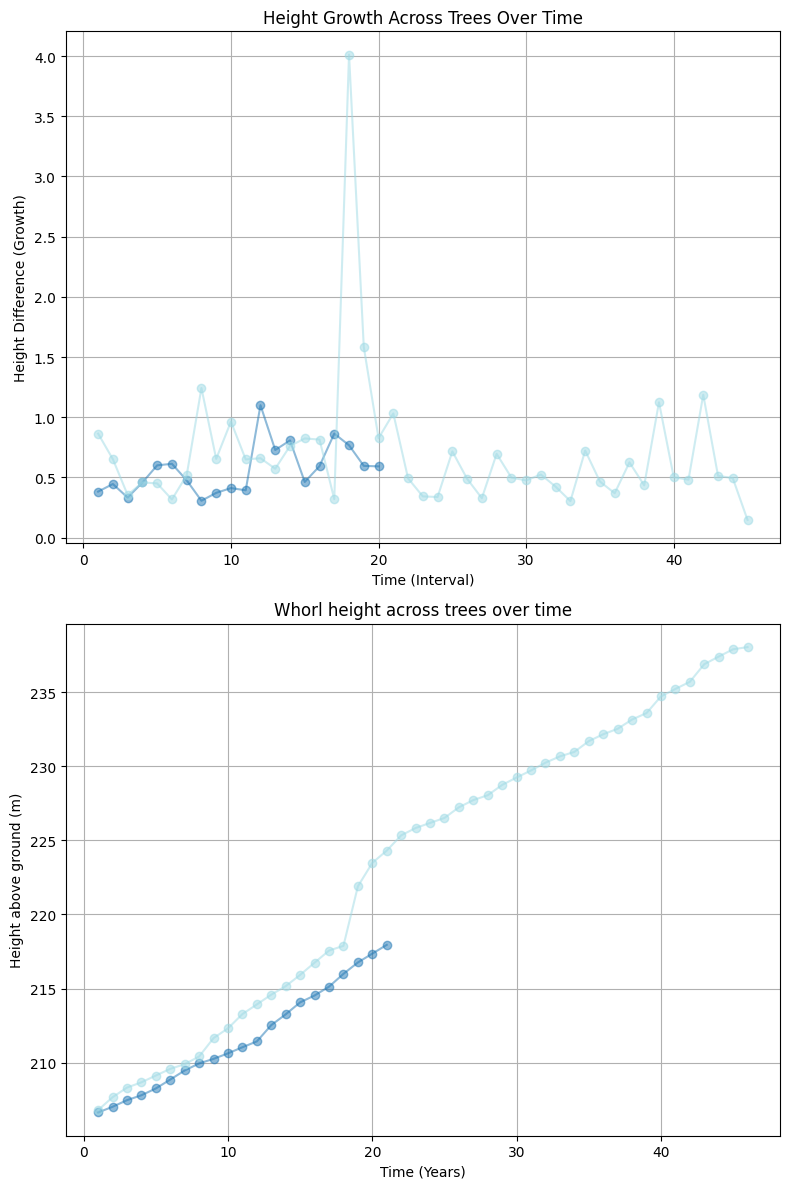

In [36]:
from matplotlib import colormaps, cm

# Define a colormap with enough distinct colors
cmap = cm.get_cmap('tab20', len(common_tree_ids))  # 'tab10' can distinguish up to 10 trees, 'tab20' for more

# Create a figure with 2 subplots (one for each plot)
fig, axs = plt.subplots(2, 1, figsize=(8, 12))

# Plot 1: Height Differences Over Time
for i, tree_id in enumerate(common_tree_ids):
    # Filter data for the current tree
    tree_whorls = whorld_df[whorld_df['treeID'] == tree_id]
    
    # Sort the whorls by height (z-coordinate)
    tree_whorls_sorted = tree_whorls.sort_values(by='z')
    
    # Calculate the height differences between consecutive whorls
    height_differences = np.diff(tree_whorls_sorted['z'])
    
    # Plot the height differences for this tree
    if len(height_differences) > 0:
        growth_x = np.arange(1, len(height_differences) + 1)  # Sequential intervals (e.g., year 1, year 2, etc.)
        axs[0].plot(growth_x, height_differences, 'o-', color=cmap(i),alpha=0.5, label=f'Tree ID: {tree_id}')

axs[0].set_xlabel('Time (Interval)')
axs[0].set_ylabel('Height Difference (Growth)')
axs[0].set_title('Height Growth Across Trees Over Time')
#axs[0].legend()
#axs[0].set_ylim(0,0.5)
axs[0].grid(True)

# Plot 2: Whorl Heights Over Time
for i, tree_id in enumerate(common_tree_ids):
    # Filter data for the current tree
    tree_whorls = whorld_df[whorld_df['treeID'] == tree_id]
    
    # Sort the whorls by height (z-coordinate)
    tree_whorls_sorted = tree_whorls.sort_values(by='z')
    
    # Extract the height values
    whorl_heights = tree_whorls_sorted['z'].values
    
    # Plot the whorl heights for this tree
    if len(whorl_heights) > 0:
        growth_x = np.arange(1, len(whorl_heights) + 1)  # Sequential intervals (e.g., year 1, year 2, etc.)
        axs[1].plot(growth_x, whorl_heights, 'o-', color=cmap(i),alpha=0.5, label=f'Tree ID: {tree_id}')

axs[1].set_xlabel('Time (Years)')
axs[1].set_ylabel('Height above ground (m)')
axs[1].set_title('Whorl height across trees over time')
#axs[1].legend()
axs[1].grid(True)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()